### Great References to study deeper:

- David Silver (DeepMind)
http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
- Richard Sutton
http://incompleteideas.net/book/the-book-2nd.html


In [ ]:
# In WinEluk use environment "cvision"
# In Valta use root environment

## Simple Neural Net in Pytorch

- Really toy problem: just fit a line...
- Code still works for torch 0.4.0
- Atamai Lec#31

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable

print('torch version:',torch.__version__)
use_cuda = torch.cuda.is_available()
print('Cuda: ', use_cuda)

torch version: 0.4.0
Cuda:  True


x shape:  torch.Size([100, 1])
Episode 0, loss 7786.1187 
Episode 50, loss 3656.6931 
Episode 100, loss 1441.9728 
Episode 150, loss 470.8453 
Episode 200, loss 124.9038 
Episode 250, loss 26.7249 
Episode 300, loss 4.7129 
Episode 350, loss 0.8218 
Episode 400, loss 0.2792 
Episode 450, loss 0.2184 
Episode 500, loss 0.2113 
Episode 550, loss 0.2087 
Episode 600, loss 0.2062 
Episode 650, loss 0.2037 
Episode 700, loss 0.2011 
Episode 750, loss 0.1984 
Episode 800, loss 0.1956 
Episode 850, loss 0.1927 
Episode 900, loss 0.1898 
Episode 950, loss 0.1867 


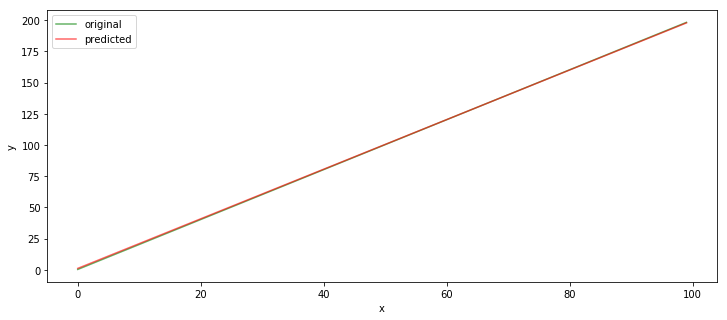

In [7]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

W = 2
b = 0.3

x = Variable(torch.arange(100).unsqueeze(1)) # To get tensor [100,1]
print('x shape: ',x.shape)
#x = Variable(torch.arange(100)) # this will not work because it produces a tensor [100]

if use_cuda:
    x = x.cuda()

y = W * x + b

###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(1,1) # out = w*x + bias
        
    def forward(self, x):
        output = self.linear1(x)
        return output
    
mynn = NeuralNetwork()

if use_cuda:
    mynn.cuda()
    
loss_func = nn.MSELoss()
#loss_func = nn.SmoothL1Loss()

optimizer = optim.Adam(params=mynn.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(params=mynn.parameters(), lr=learning_rate)

for i_episode in range(num_episodes):
    
    predicted_value = mynn(x)
    
    loss = loss_func(predicted_value, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i_episode % 50 == 0:
        #print("Episode %i, loss %.4f " % (i_episode, loss.data[0]))
        print("Episode %i, loss %.4f " % (i_episode, loss.data.item()))
    
    
plt.figure(figsize=(12,5))
plt.plot(x.data.cpu().numpy(), y.data.cpu().numpy(), alpha=0.6, color='green')
plt.plot(x.data.cpu().numpy(), predicted_value.data.cpu().numpy(), alpha=0.6, color='red')
plt.xlabel('x'), plt.ylabel('y')
plt.legend(['original','predicted'])
plt.show()

## CartPole-v0: "Q-learning" + Neural Net (simple Linear regression)

- Neural net will work as a function F, where action = F(state)
- GOAL: be able to keep the pole for >195 steps, that is, reward>195

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

*** Episode 0 ***                 
 Avg.Reward [last 500]: 0.03, [last 100]: 0.14, [all]: 14.00                
 epsilon: 0.88, cont_steps= 14
Elapsed time:  00:00:00

*** Episode 500 ***                 
 Avg.Reward [last 500]: 10.05, [last 100]: 9.43, [all]: 10.06                
 epsilon: 0.02, cont_steps= 5038
Elapsed time:  00:00:07

*** Episode 1000 ***                 
 Avg.Reward [last 500]: 13.75, [last 100]: 23.80, [all]: 11.90                
 epsilon: 0.02, cont_steps= 11912
Elapsed time:  00:00:17

*** Episode 1500 ***                 
 Avg.Reward [last 500]: 26.43, [last 100]: 30.02, [all]: 16.74                
 epsilon: 0.02, cont_steps= 25128
Elapsed time:  00:00:33

*** Episode 2000 ***                 
 Avg.Reward [last 500]: 26.35, [last 100]: 24.92, [all]: 19.14                
 epsilon: 0.02, cont_steps= 38301
Elapsed time:  00:00:47

*** Episode 2500 ***           

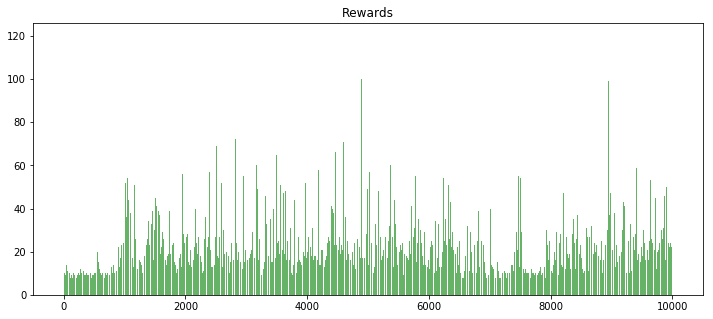

In [10]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Debug mode
debug = False

# Set CPU or GPU device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu") 

# Set Gym environment
env = gym.make('CartPole-v0')

# Set seeds
seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

# PARAMS
num_episodes = 10000
gamma = 0.85
my_lr = 0.01
score_goal = 195 # official

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

# e-Greedy strategy
def calc_epsilon(nsteps):
    epsilon = egreedy_final + \
       (egreedy - egreedy_final)*math.exp(-1.*nsteps/egreedy_decay) 
    return epsilon

# NEURAL NETWORK
n_inputs = env.observation_space.shape[0] 
n_outputs = env.action_space.n

# 1) Define the NN architecture
class NeuralNet(nn.Module): # self inherits the class nn.Module
    def __init__(self):
        super(NeuralNet, self).__init__() # Call parent's init
        self.linear1 = nn.Linear(n_inputs,n_outputs) # simple layer
        
    def forward(self,x):
        output = self.linear1(x)
        return output
    
# 2) Define the NN-agent
class Qnet_agent():
    # 1) Init
    def __init__(self):
        # a) Architecture
        self.nn = NeuralNet().to(device)
        # b) Loss
        self.loss = nn.MSELoss() # linear regression
        # c) Optim
        self.optimizer = optim.Adam(params=self.nn.parameters(),lr=my_lr)
        
    # 2) Action
    def select_action(self,state,epsilon):
        # e-greedy with Exploit x Explore trade-off
        randx = torch.rand(1)[0]
        
        if randx > epsilon:
            # Exploit
            with torch.no_grad(): # more efficient than detach()
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action_index = torch.max(action_from_nn,0)[1] # 1 for the index
                action = action_index.item()
                
                if debug:
                    print('--> Exploit action_from_nn[',action_from_nn,'] action:',action)
        else:
            # Explore
            action = env.action_space.sample()
            if debug:
                print('--> Explore: action:',action)
            
        return action
    
    # 3) Optimize
    def optimize(self,state,action,new_state,reward,done):
        # - Variable and Tensor are identical classes
        state = torch.Tensor(state).to(device) # Convert to tensor
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor([reward]).to(device) # since others are list, reward has to be in list format
        
        if done:
            target_value = reward # episode is completed
        else:
            ## Bellman's equation (- Traditional way -)
            # Q[state,action] = reward + gamma*torch.max(Q[new_state])
        
            # We will use NNet instead to Approx Q (- New way -)
            new_state_values = self.nn(new_state).detach() # leave the grad
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma*max_new_state_values
        
        ## Q-learning: use prediction-error to update Q
        # (-- Traditional way --)
        # Q[state, action] = (1 - lr) * Q[state, action] \
        #    + lr * (reward + gamma * torch.max(Q[new_state]))
        # (-- New way --)    
        # Current state
        predicted_value = self.nn(state)[action] # here we carry grad because it will update
        # Prediction error
        loss = self.loss(predicted_value,target_value)
        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() # update params
        

# 3) RL part
agent = Qnet_agent()
steps_total = []
all_solved_nepisodes = []
cont_steps = 0
tic = time.time()
for i_episode in range(num_episodes):
    
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        cont_steps += 1 # will keep across episodes
        epsilon = calc_epsilon(cont_steps) 
        
        # Action is selected
        action = agent.select_action(state,epsilon)
        
        # Next environment
        new_state, reward, done, info = env.step(action)
        # States: [cart position,cart velocity,pole angle, pole velocity]
        
        # Update NNet
        agent.optimize(state,action,new_state,reward,done)
        
        if debug:
            print('Step#%d: %s, state:%s'%(step,action,new_state))
            #print(info)
            env.render()
            input("")
        
        # Prepare next iteration
        state = new_state
        
        if done:
            steps_total.append(step)
            #print("Episode finished after %i steps" % step )
            
            avgReward100 = sum(steps_total[-100:])/100
            
            if avgReward100 > score_goal:
                print('SOLVED! After %d episodes' %(i_episode))
                all_solved_nepisodes.append(i_episodes)
                
                break
            
            # Better reporting
            interval = 500
            if i_episode % interval == 0:
                print('\n*** Episode %i *** \
                \n Avg.Reward [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f\
                \n epsilon: %.2f, cont_steps= %d'%
                      (i_episode, interval,
                      sum(steps_total[-interval:])/interval,
                      avgReward100,
                      sum(steps_total)/len(steps_total),
                       epsilon, cont_steps
                      ))
                toc = time.time()
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(toc-tic)))
            
            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
print("Number of solved times: ", len(all_solved_nepisodes))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()

## CartPole-v0: "Q-learning" + Neural Net (2 layers)

- We will add 1 additional layers to input some non-linearity
- Neural net will work as a function F, where action = F(state)
- GOAL: be able to keep the pole for >195 steps, that is, reward>195

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

*** Episode 0 ***                 
 Avg.Reward [last 50]: 0.38, [last 100]: 0.19, [all]: 19.00                
 epsilon: 0.87, cont_steps= 19
Elapsed time:  00:00:00

*** Episode 50 ***                 
 Avg.Reward [last 50]: 38.12, [last 100]: 19.25, [all]: 37.75                
 epsilon: 0.04, cont_steps= 1925
Elapsed time:  00:00:04

*** Episode 100 ***                 
 Avg.Reward [last 50]: 95.76, [last 100]: 66.94, [all]: 66.47                
 epsilon: 0.02, cont_steps= 6713
Elapsed time:  00:00:14

*** Episode 150 ***                 
 Avg.Reward [last 50]: 152.46, [last 100]: 124.11, [all]: 94.94                
 epsilon: 0.02, cont_steps= 14336
Elapsed time:  00:00:28

*** Episode 200 ***                 
 Avg.Reward [last 50]: 167.10, [last 100]: 159.78, [all]: 112.89                
 epsilon: 0.02, cont_steps= 22691
Elapsed time:  00:00:45

*** Episode 250 ***                

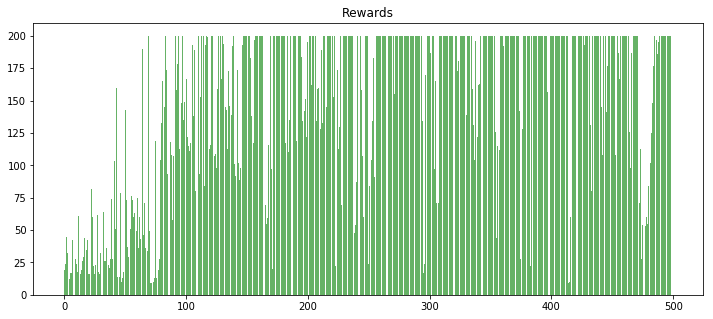

In [39]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Debug mode
debug = False

# Set CPU or GPU device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu") 

# Set Gym environment
env = gym.make('CartPole-v0')

# Set seeds
seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

# PARAMS
num_episodes = 500
score_goal = 195 # official

gamma = 0.99
my_lr = 0.02
nhidden = 64

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

# e-Greedy strategy
def calc_epsilon(nsteps):
    epsilon = egreedy_final + \
       (egreedy - egreedy_final)*math.exp(-1.*nsteps/egreedy_decay) 
    return epsilon

# NEURAL NETWORK
n_inputs = env.observation_space.shape[0] 
n_outputs = env.action_space.n

# 1) Define the NN architecture
class NeuralNet(nn.Module): # self inherits the class nn.Module
    def __init__(self):
        super(NeuralNet, self).__init__() # Call parent's init
        self.linear1 = nn.Linear(n_inputs,nhidden) # input
        self.linear2 = nn.Linear(nhidden,n_outputs) # layer 2
        
        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
    def forward(self,x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        #output2 = self.activation(output2)
        #output3 = self.linear3(output2)
        
        return output2
    
# 2) Define the NN-agent
class Qnet_agent():
    # 1) Init
    def __init__(self):
        # a) Architecture
        self.nn = NeuralNet().to(device)
        # b) Loss
        self.loss = nn.MSELoss() # linear regression
        # c) Optim
        self.optimizer = optim.Adam(params=self.nn.parameters(),lr=my_lr)
        
    # 2) Action
    def select_action(self,state,epsilon):
        # e-greedy with Exploit x Explore trade-off
        randx = torch.rand(1)[0]
        
        if randx > epsilon:
            # Exploit
            with torch.no_grad(): # more efficient than detach()
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action_index = torch.max(action_from_nn,0)[1] # 1 for the index
                action = action_index.item()
                
                if debug:
                    print('--> Exploit action_from_nn[',action_from_nn,'] action:',action)
        else:
            # Explore
            action = env.action_space.sample()
            if debug:
                print('--> Explore: action:',action)
            
        return action
    
    # 3) Optimize
    def optimize(self,state,action,new_state,reward,done):
        # - Variable and Tensor are identical classes
        state = torch.Tensor(state).to(device) # Convert to tensor
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor([reward]).to(device) # since others are list, reward has to be in list format
        
        if done:
            target_value = reward # episode is completed
        else:
            ## Bellman's equation (- Traditional way -)
            # Q[state,action] = reward + gamma*torch.max(Q[new_state])
        
            # We will use NNet instead to Approx Q (- New way -)
            new_state_values = self.nn(new_state).detach() # leave the grad
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma*max_new_state_values
        
        ## Q-learning: use prediction-error to update Q
        # (-- Traditional way --)
        # Q[state, action] = (1 - lr) * Q[state, action] \
        #    + lr * (reward + gamma * torch.max(Q[new_state]))
        # (-- New way --)    
        # Current state
        predicted_value = self.nn(state)[action] # here we carry grad because it will update
        # Prediction error
        loss = self.loss(predicted_value,target_value)
        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() # update params
        

# 3) RL part
agent = Qnet_agent()
steps_total = []
all_solved_nepisodes = []
cont_steps = 0
tic = time.time()
for i_episode in range(num_episodes):
    
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        cont_steps += 1 # will keep across episodes
        epsilon = calc_epsilon(cont_steps) 
        
        # Action is selected
        action = agent.select_action(state,epsilon)
        
        # Next environment
        new_state, reward, done, info = env.step(action)
        # States: [cart position,cart velocity,pole angle, pole velocity]
        
        # Update NNet
        agent.optimize(state,action,new_state,reward,done)
        
        if debug:
            print('Step#%d: %s, state:%s'%(step,action,new_state))
            #print(info)
            env.render()
            input("")
        
        # Prepare next iteration
        state = new_state
        
        if done:
            steps_total.append(step)
            #print("Episode finished after %i steps" % step )
            
            avgReward100 = sum(steps_total[-100:])/100
            
            if avgReward100 > score_goal:
                print('SOLVED! After %d episodes' %(i_episode))
                all_solved_nepisodes.append(i_episodes)
                
                break
            
            # Better reporting
            interval = 50
            if i_episode % interval == 0:
                print('\n*** Episode %i *** \
                \n Avg.Reward [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f\
                \n epsilon: %.2f, cont_steps= %d'%
                      (i_episode, interval,
                      sum(steps_total[-interval:])/interval,
                      avgReward100,
                      sum(steps_total)/len(steps_total),
                       epsilon, cont_steps
                      ))
                toc = time.time()
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(toc-tic)))
            
            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
print("Number of solved times: ", len(all_solved_nepisodes))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()


## CartPole-v0: "Q-learning" + Neural Net (3 layers) 
## --> DID NOT IMPROVE...

- We will add 2 additional layers to input some non-linearity
- Neural net will work as a function F, where action = F(state)
- GOAL: be able to keep the pole for >195 steps, that is, reward>195

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.

*** Episode 0 ***                 
 Avg.Reward [last 50]: 0.26, [last 100]: 0.13, [all]: 13.00                
 epsilon: 0.88, cont_steps= 13
Elapsed time:  00:00:00

*** Episode 50 ***                 
 Avg.Reward [last 50]: 48.62, [last 100]: 24.44, [all]: 47.92                
 epsilon: 0.03, cont_steps= 2444
Elapsed time:  00:00:05

*** Episode 100 ***                 
 Avg.Reward [last 50]: 134.80, [last 100]: 91.71, [all]: 90.93                
 epsilon: 0.02, cont_steps= 9184
Elapsed time:  00:00:21

*** Episode 150 ***                 
 Avg.Reward [last 50]: 120.72, [last 100]: 127.76, [all]: 100.79                
 epsilon: 0.02, cont_steps= 15220
Elapsed time:  00:00:34

*** Episode 200 ***                 
 Avg.Reward [last 50]: 64.46, [last 100]: 92.59, [all]: 91.76                
 epsilon: 0.02, cont_steps= 18443
Elapsed time:  00:00:42

*** Episode 250 ***                 

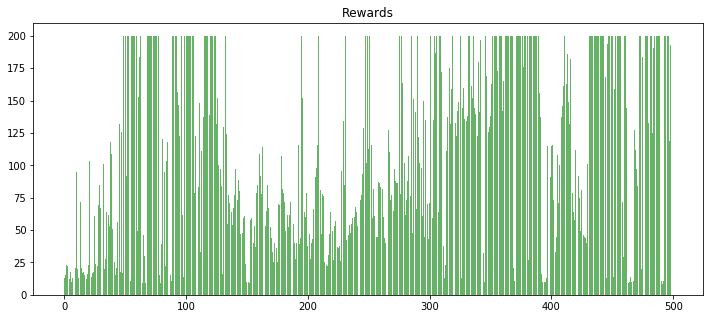

In [15]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import time

import matplotlib.pyplot as plt
%matplotlib inline

# Debug mode
debug = False

# Set CPU or GPU device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu") 

# Set Gym environment
env = gym.make('CartPole-v0')

# Set seeds
seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

# PARAMS
num_episodes = 500
score_goal = 195 # official

gamma = 0.99
my_lr = 0.01
nhidden = [32,32]

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

# e-Greedy strategy
def calc_epsilon(nsteps):
    epsilon = egreedy_final + \
       (egreedy - egreedy_final)*math.exp(-1.*nsteps/egreedy_decay) 
    return epsilon

# NEURAL NETWORK
n_inputs = env.observation_space.shape[0] 
n_outputs = env.action_space.n

# 1) Define the NN architecture
class NeuralNet(nn.Module): # self inherits the class nn.Module
    def __init__(self):
        super(NeuralNet, self).__init__() # Call parent's init
        self.linear1 = nn.Linear(n_inputs,nhidden[0]) # input
        self.linear2 = nn.Linear(nhidden[0],nhidden[1]) # layer 1
        self.linear3 = nn.Linear(nhidden[1],n_outputs) # layer 3
        
        self.activation = nn.Tanh()
        #self.activation = nn.ReLU()
        
    def forward(self,x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        output2 = self.activation(output2)
        output3 = self.linear3(output2)
        
        return output3
    
# 2) Define the NN-agent
class Qnet_agent():
    # 1) Init
    def __init__(self):
        # a) Architecture
        self.nn = NeuralNet().to(device)
        # b) Loss
        self.loss = nn.MSELoss() # linear regression
        # c) Optim
        self.optimizer = optim.Adam(params=self.nn.parameters(),lr=my_lr)
        
    # 2) Action
    def select_action(self,state,epsilon):
        # e-greedy with Exploit x Explore trade-off
        randx = torch.rand(1)[0]
        
        if randx > epsilon:
            # Exploit
            with torch.no_grad(): # more efficient than detach()
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action_index = torch.max(action_from_nn,0)[1] # 1 for the index
                action = action_index.item()
                
                if debug:
                    print('--> Exploit action_from_nn[',action_from_nn,'] action:',action)
        else:
            # Explore
            action = env.action_space.sample()
            if debug:
                print('--> Explore: action:',action)
            
        return action
    
    # 3) Optimize
    def optimize(self,state,action,new_state,reward,done):
        # - Variable and Tensor are identical classes
        state = torch.Tensor(state).to(device) # Convert to tensor
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor([reward]).to(device) # since others are list, reward has to be in list format
        
        if done:
            target_value = reward # episode is completed
        else:
            ## Bellman's equation (- Traditional way -)
            # Q[state,action] = reward + gamma*torch.max(Q[new_state])
        
            # We will use NNet instead to Approx Q (- New way -)
            new_state_values = self.nn(new_state).detach() # leave the grad
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma*max_new_state_values
        
        ## Q-learning: use prediction-error to update Q
        # (-- Traditional way --)
        # Q[state, action] = (1 - lr) * Q[state, action] \
        #    + lr * (reward + gamma * torch.max(Q[new_state]))
        # (-- New way --)    
        # Current state
        predicted_value = self.nn(state)[action] # here we carry grad because it will update
        # Prediction error
        loss = self.loss(predicted_value,target_value)
        # Backprop
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step() # update params
        

# 3) RL part
agent = Qnet_agent()
steps_total = []
all_solved_nepisodes = []
cont_steps = 0
tic = time.time()
for i_episode in range(num_episodes):
    
    state = env.reset()
    step = 0

    while True:
        
        step += 1
        
        cont_steps += 1 # will keep across episodes
        epsilon = calc_epsilon(cont_steps) 
        
        # Action is selected
        action = agent.select_action(state,epsilon)
        
        # Next environment
        new_state, reward, done, info = env.step(action)
        # States: [cart position,cart velocity,pole angle, pole velocity]
        
        # Update NNet
        agent.optimize(state,action,new_state,reward,done)
        
        if debug:
            print('Step#%d: %s, state:%s'%(step,action,new_state))
            #print(info)
            env.render()
            input("")
        
        # Prepare next iteration
        state = new_state
        
        if done:
            steps_total.append(step)
            #print("Episode finished after %i steps" % step )
            
            avgReward100 = sum(steps_total[-100:])/100
            
            if avgReward100 > score_goal:
                print('SOLVED! After %d episodes' %(i_episode))
                all_solved_nepisodes.append(i_episodes)
                
                break
            
            # Better reporting
            interval = 50
            if i_episode % interval == 0:
                print('\n*** Episode %i *** \
                \n Avg.Reward [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f\
                \n epsilon: %.2f, cont_steps= %d'%
                      (i_episode, interval,
                      sum(steps_total[-interval:])/interval,
                      avgReward100,
                      sum(steps_total)/len(steps_total),
                       epsilon, cont_steps
                      ))
                toc = time.time()
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(toc-tic)))
            
            break
        

print("Average reward: %.2f" % (sum(steps_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
print("Number of solved times: ", len(all_solved_nepisodes))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
plt.show()

env.close()
env.env.close()
